<a href="https://colab.research.google.com/github/liamcarroll/pig-latin-dataproc/blob/main/recsys.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import everything we need

In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from __future__ import print_function
import numpy as np
import pandas as pd
import collections
from mpl_toolkits.mplot3d import Axes3D
from IPython import display
from matplotlib import pyplot as plt
import sklearn
import sklearn.manifold
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.logging.set_verbosity(tf.logging.ERROR)

# Add some convenience functions to Pandas DataFrame.
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.3f}'.format
def mask(df, key, function):
  """Returns a filtered dataframe, by applying function to key"""
  return df[function(df[key])]

def flatten_cols(df):
  df.columns = [' '.join(col).strip() for col in df.columns.values]
  return df

pd.DataFrame.mask = mask
pd.DataFrame.flatten_cols = flatten_cols

# Install Altair and activate its colab renderer.
print("Installing Altair...")
!pip install git+git://github.com/altair-viz/altair.git
import altair as alt
alt.data_transformers.enable('default', max_rows=None)
alt.renderers.enable('colab')
print("Done installing Altair.")

Instructions for updating:
non-resource variables are not supported in the long term
Installing Altair...
  Cloning git://github.com/altair-viz/altair.git to /tmp/pip-req-build-hbemxgpc
  Running command git clone -q git://github.com/altair-viz/altair.git /tmp/pip-req-build-hbemxgpc
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for altair: filename=altair-4.2.0.dev0-cp36-none-any.whl size=730117 sha256=7c02e7df2288d8992efd5fa11230e3465e2b775ac2b07daa5a81e857241f400f
  Stored in directory: /tmp/pip-ephem-wheel-cache-2fjcq127/wheels/01/fd/91/025b6149b3949af76e93b3b3ceca5bf12cbdebc98fa46f9ec6
Successfully built altair
Done installing Altair.


## Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
os.chdir('/content/drive/My Drive/CA4015/Assignment_4/')
#os.chdir('/content/drive/My Drive/College - 4th Year/CA4015_AdvancedML/Assignment_4/') # Liam

## Section II - Preliminaries



## Build Sparse Tensor

The ratings matrix we build will be quite large, with lots of unobserved entries, as users will only have ratings for a relatively small subset of artists. Therefore it makes to sense to use a Tensorflow Sparse Tensor for an efficient representation of the data. 

In [ ]:
def build_rating_sparse_tensor(user_artists_df):

  indices = user_artists_df[['userID', 'artistID']].values
  values = user_artists_df['weight'].values

  return tf.SparseTensor(
      indices=indices,
      values=values,
      dense_shape=[len(user_artists.userID.unique()), artists.shape[0]])

Load all of our nice clean data

In [ ]:
user_artists = pd.read_csv('data_clean/user_artists_0041.csv')
user_friends = pd.read_csv('data_clean/user_friends.csv')
u_t_artists = pd.read_csv('data_clean/u_t_artists.csv')
uta_timestamps = pd.read_csv('data_clean/uta_timestamps.csv')
artists = pd.read_csv('data_clean/artists.csv')
tags = pd.read_csv('data_clean/tags.csv')

## Mean Square Error
We need a method for measuring the approximation error in our model. We will be using Mean Square Error, defined below

$$
\begin{align*}
\text{MSE}(A, UV^\top)
&= \frac{1}{|\Omega|}\sum_{(i, j) \in\Omega}{( A_{ij} - (UV^\top)_{ij})^2} \\
&= \frac{1}{|\Omega|}\sum_{(i, j) \in\Omega}{( A_{ij} - \langle U_i, V_j\rangle)^2}
\end{align*}
$$
where $\Omega$ is the set of observed ratings, and $|\Omega|$ is the cardinality of $\Omega$.

This function below will calculate our Mean Square Error

In [ ]:
def sparse_mean_square_error(sparse_ratings, user_embeddings, music_embeddings):

  predictions = tf.reduce_sum(
      tf.gather(user_embeddings, sparse_ratings.indices[:, 0]) *
      tf.gather(music_embeddings, sparse_ratings.indices[:, 1]),
      axis=1)
  loss = tf.losses.mean_squared_error(sparse_ratings.values, predictions)
  return loss

## Section III - Training Factorization Model

Collaborative Filtering Model 

This class trains a matrix factorization model using stochastic gradient descent.

In [ ]:
class CFModel(object):
  """Simple class that represents a collaborative filtering model"""
  def __init__(self, embedding_vars, loss, metrics=None):
    """Initializes a CFModel.
    Args:
      embedding_vars: A dictionary of tf.Variables.
      loss: A float Tensor. The loss to optimize.
      metrics: optional list of dictionaries of Tensors. The metrics in each
        dictionary will be plotted in a separate figure during training.
    """
    self._embedding_vars = embedding_vars
    self._loss = loss
    self._metrics = metrics
    self._embeddings = {k: None for k in embedding_vars}
    self._session = None

  @property
  def embeddings(self):
    """The embeddings dictionary."""
    return self._embeddings

  def train(self, num_iterations=100, learning_rate=1.0, plot_results=True,
            optimizer=tf.train.GradientDescentOptimizer):
    """Trains the model.
    Args:
      iterations: number of iterations to run.
      learning_rate: optimizer learning rate.
      plot_results: whether to plot the results at the end of training.
      optimizer: the optimizer to use. Default to GradientDescentOptimizer.
    Returns:
      The metrics dictionary evaluated at the last iteration.
    """
    with self._loss.graph.as_default():
      opt = optimizer(learning_rate)
      train_op = opt.minimize(self._loss)
      local_init_op = tf.group(
          tf.variables_initializer(opt.variables()),
          tf.local_variables_initializer())
      if self._session is None:
        self._session = tf.Session()
        with self._session.as_default():
          self._session.run(tf.global_variables_initializer())
          self._session.run(tf.tables_initializer())
          tf.train.start_queue_runners()

    with self._session.as_default():
      local_init_op.run()
      iterations = []
      metrics = self._metrics or ({},)
      metrics_vals = [collections.defaultdict(list) for _ in self._metrics]

      # Train and append results.
      for i in range(num_iterations + 1):
        _, results = self._session.run((train_op, metrics))
        if (i % 10 == 0) or i == num_iterations:
          print("\r iteration %d: " % i + ", ".join(
                ["%s=%f" % (k, v) for r in results for k, v in r.items()]),
                end='')
          iterations.append(i)
          for metric_val, result in zip(metrics_vals, results):
            for k, v in result.items():
              metric_val[k].append(v)

      for k, v in self._embedding_vars.items():
        self._embeddings[k] = v.eval()

      if plot_results:
        # Plot the metrics.
        num_subplots = len(metrics)+1
        fig = plt.figure()
        fig.set_size_inches(num_subplots*10, 8)
        for i, metric_vals in enumerate(metrics_vals):
          ax = fig.add_subplot(1, num_subplots, i+1)
          for k, v in metric_vals.items():
            ax.plot(iterations, v, label=k)
          ax.set_xlim([1, num_iterations])
          ax.legend()
      return results

## Building the Model

Now we define a function to build our model, using the Mean Square Error function and the Sparse Tensor function to build our model

In [ ]:
def build_model(ratings, embedding_dim=3, init_stddev=1.):

  # Split the ratings DataFrame into train and test.
  train_ratings, test_ratings = split_dataframe(ratings)
  # SparseTensor representation of the train and test datasets.
  A_train = build_rating_sparse_tensor(train_ratings)
  A_test = build_rating_sparse_tensor(test_ratings)
  # Initialize the embeddings using a normal distribution.
  U = tf.Variable(tf.random.normal(
      [A_train.dense_shape[0], embedding_dim], stddev=init_stddev))
  V = tf.Variable(tf.random.normal(
      [A_train.dense_shape[1], embedding_dim], stddev=init_stddev))
  train_loss = sparse_mean_square_error(A_train, U, V)
  test_loss = sparse_mean_square_error(A_test, U, V)
  metrics = {
      'train_error': train_loss,
      'test_error': test_loss
  }
  embeddings = {
      "userID": U,
      "artistID": V
  }
  return CFModel(embeddings, train_loss, [metrics])

This is a simple function that will split the data into a training and test set, we will need these to train and test the models. It is used by the previous defined function, build_model

In [ ]:
def split_dataframe(df, holdout_fraction=0.1):
  
  test = df.sample(frac=holdout_fraction, replace=False)
  train = df[~df.index.isin(test.index)]
  return train, test

We now want to drop any columns in the data that we don't need. For our Collaborative Filtering we only need User ID, Artist ID and the weight or rating

In [ ]:
user_artists = user_artists[['userID', 'artistID', 'weight']]

We make sure the columns are the correct data types for our model here. We need a String for User ID and Artist ID and a float for our weight.

In [ ]:
user_artists['userID'] = user_artists['userID'].astype(str)
user_artists['artistID'] = user_artists['artistID'].astype(str)
user_artists['weight'] = user_artists['weight'].astype(float)
user_artists = user_artists.sample(frac=1).reset_index(drop=True)

## Build and train the Collaborative Filtering Model

 iteration 1000: train_error=0.169348, test_error=3.810666

[{'test_error': 3.810666, 'train_error': 0.16934827}]

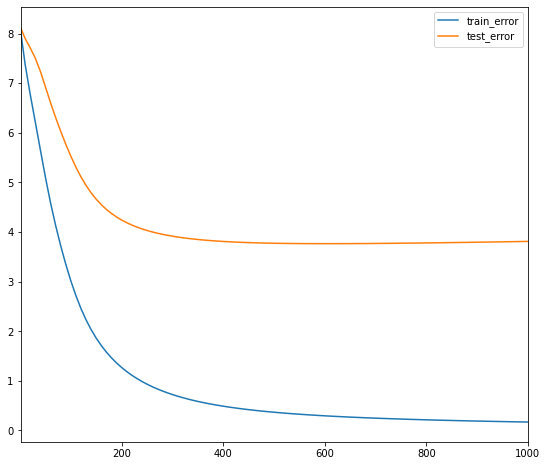

In [ ]:
model = build_model(user_artists, embedding_dim=30, init_stddev=0.5)
model.train(num_iterations=1000, learning_rate=10.)

## Section IV - Inspect Embeddings

In [ ]:
DOT = 'dot'
COSINE = 'cosine'
def compute_scores(query_embedding, item_embeddings, measure=DOT):

  u = query_embedding
  V = item_embeddings
  if measure == COSINE:
    V = V / np.linalg.norm(V, axis=1, keepdims=True)
    u = u / np.linalg.norm(u)
  scores = u.dot(V.T)
  return scores

In [ ]:
def artist_neighbors(model, title_substring, measure=DOT, k=6):
  ids =  artists[artists['name'].str.contains(title_substring)].index.values
  titles = artists.iloc[ids]['name'].values
  if len(titles) == 0:
    raise ValueError("Found no artist with title %s" % title_substring)
  print("Nearest neighbors of : %s." % titles[0])
  if len(titles) > 1:
    print("[Found more than one matching artist. Other candidates: {}]".format(
        ", ".join(titles[1:])))
  artistID = ids[0]
  scores = compute_scores(
      model.embeddings["artistID"][artistID], model.embeddings["artistID"],
      measure)
  score_key = measure + ' score'
  df = pd.DataFrame({
      score_key: list(scores),
      'names': artists['name'],
  })
  display.display(df.sort_values([score_key], ascending=False).head(k))

In [ ]:
artist_neighbors(model, "The Beatles", DOT)
artist_neighbors(model, "The Beatles", COSINE)

Nearest neighbors of : The Beatles.
[Found more than one matching artist. Other candidates: The Beatles with Billy Preston]


,dot score,names
221,7.986,The Beatles
148,6.583,Radiohead
157,5.994,Pink Floyd
505,5.907,U2
412,5.869,Sigur Rós
5572,5.859,Black Country Communion


Nearest neighbors of : The Beatles.
[Found more than one matching artist. Other candidates: The Beatles with Billy Preston]


,cosine score,names
221,1.000,The Beatles
148,0.878,Radiohead
176,0.808,Keane
157,0.800,Pink Floyd
59,0.781,Coldplay
703,0.781,The White Stripes


 iteration 1000: train_error=0.287540, test_error=1.434729Nearest neighbors of : The Beatles.
[Found more than one matching artist. Other candidates: The Beatles with Billy Preston]


,dot score,names
221,15.698,The Beatles
83,4.880,Lady Gaga
950,4.850,Queen
227,4.802,Nine Inch Nails
698,4.524,The Pretty Reckless
45,4.205,Duran Duran


Nearest neighbors of : The Beatles.
[Found more than one matching artist. Other candidates: The Beatles with Billy Preston]


,cosine score,names
221,1.000,The Beatles
15296,0.716,Dixie Dregs
13013,0.684,Nina Sky
2406,0.674,Billie Holiday & Teddy Wilson & His Orchestra
11292,0.669,Kazuhito Yamashita
8858,0.658,Lia


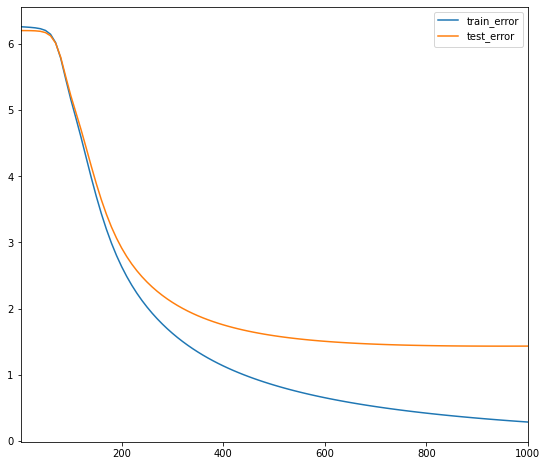

In [ ]:
model_lowinit = build_model(user_artists, embedding_dim=30, init_stddev=0.05)
model_lowinit.train(num_iterations=1000, learning_rate=10.)
artist_neighbors(model_lowinit, "The Beatles", DOT)
artist_neighbors(model_lowinit, "The Beatles", COSINE)

## Section V - Regularization in Matrix Factorization

In the previous section, our loss was defined as the mean squared error on the observed part of the rating matrix. As discussed in the lecture, this can be problematic as the model does not learn how to place the embeddings of irrelevant movies. This phenomenon is known as folding.

We will add regularization terms that will address this issue. We will use two types of regularization:

Up until now we have been using Mean Square Error for our loss. This can cause problems however, as the model never learns how to place the embeddings for irrelevant movies in the dataset. This is known as "folding". There are two regularization terms we can add to help address this. 

Regularization of the model parameters, defined below:

$r(U, V) =  \frac{1}{N} \sum_i \|U_i\|^2 + \frac{1}{M}\sum_j \|V_j\|^2$.

A "gravity" term which is used to push the prediction of any pair towards zero, This is given by:

 $g(U, V) = \frac{1}{MN} \sum_{i = 1}^N \sum_{j = 1}^M \langle U_i, V_j \rangle^2$.

Therefore the total loss is now:

 $$
\frac{1}{|\Omega|}\sum_{(i, j) \in \Omega} (A_{ij} - \langle U_i, V_j\rangle)^2 + \lambda _r r(U, V) + \lambda_g g(U, V)
$$

where $\lambda_r$ and $\lambda_g$ are two regularization coefficients (hyper-parameters).

In [ ]:
def gravity(U, V):
  """Creates a gravity loss given two embedding matrices."""
  return 1. / (U.shape[0].value*V.shape[0].value) * tf.reduce_sum(
      tf.matmul(U, U, transpose_a=True) * tf.matmul(V, V, transpose_a=True))

def build_regularized_model(
    ratings, embedding_dim=3, regularization_coeff=.1, gravity_coeff=1.,
    init_stddev=0.1):
  # Split the ratings DataFrame into train and test.
  train_ratings, test_ratings = split_dataframe(ratings)
  # SparseTensor representation of the train and test datasets.
  A_train = build_rating_sparse_tensor(train_ratings)
  A_test = build_rating_sparse_tensor(test_ratings)
  U = tf.Variable(tf.random_normal(
      [A_train.dense_shape[0], embedding_dim], stddev=init_stddev))
  V = tf.Variable(tf.random_normal(
      [A_train.dense_shape[1], embedding_dim], stddev=init_stddev))

  error_train = sparse_mean_square_error(A_train, U, V)
  error_test = sparse_mean_square_error(A_test, U, V)
  gravity_loss = gravity_coeff * gravity(U, V)
  regularization_loss = regularization_coeff * (
      tf.reduce_sum(U*U)/U.shape[0].value + tf.reduce_sum(V*V)/V.shape[0].value)
  total_loss = error_train + regularization_loss + gravity_loss
  losses = {
      'train_error_observed': error_train,
      'test_error_observed': error_test,
  }
  loss_components = {
      'observed_loss': error_train,
      'regularization_loss': regularization_loss,
      'gravity_loss': gravity_loss,
  }
  embeddings = {"userId": U, "artistID": V}

  return CFModel(embeddings, total_loss, [losses, loss_components]), U, V

Now we build and train this Regularized model

 iteration 2000: train_error_observed=0.144180, test_error_observed=2.168423, observed_loss=0.144180, regularization_loss=0.420827, gravity_loss=0.179640

[{'test_error_observed': 2.1684232, 'train_error_observed': 0.14417969},
 {'gravity_loss': 0.17963986,
  'observed_loss': 0.14417969,
  'regularization_loss': 0.42082682}]

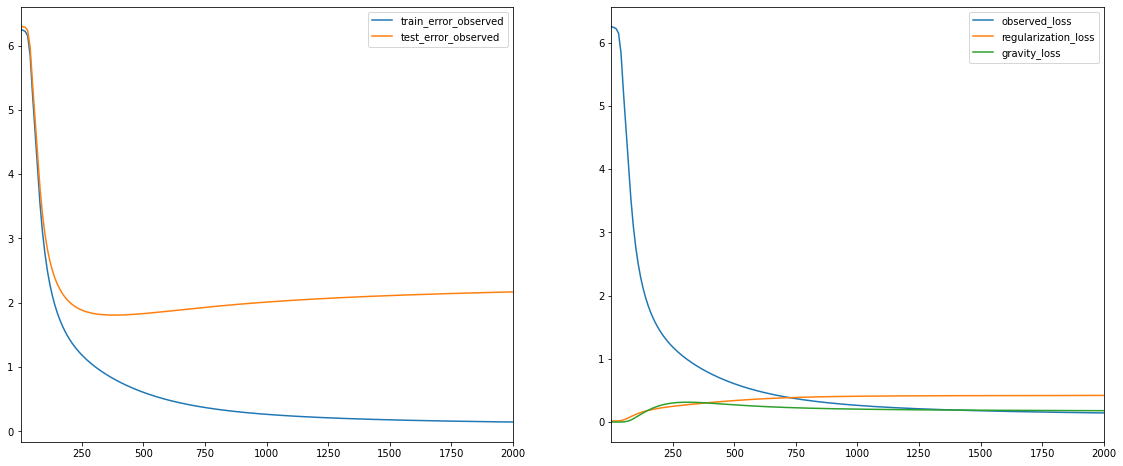

In [ ]:
reg_model, u, v = build_regularized_model(
    user_artists, regularization_coeff=0.1, gravity_coeff=1.0, embedding_dim=35,
    init_stddev=.05)
reg_model.train(num_iterations=2000, learning_rate=20.)

In [ ]:
artist_neighbors(reg_model, "The Smiths", DOT)
artist_neighbors(reg_model, "The Smiths", COSINE)

Nearest neighbors of : The Smiths.


,dot score,names
423,20.369,The Smiths
167,12.603,Placebo
66,11.923,Depeche Mode
197,11.619,Blur
527,11.370,Oasis
2511,11.174,Morrissey


Nearest neighbors of : The Smiths.


,cosine score,names
423,1.000,The Smiths
2593,0.824,Mr Hudson & The Library
7027,0.711,Eight Legs
437,0.709,The Rakes
11793,0.707,Richard Hell and the Voidoids
11797,0.704,The Social


The regularized model has done a great job here, even recommending Morrissey to fans of The Smiths, the band with whom he was the frontman. Interestingly, the test error is actually higher than the non regulized versions while the recommendations are arguably better.

This shows us that fitting the observed data often emphasizes learning high similarity (between items with lots of interactions), but a solid embedding representation also requires learning low similarity (between items with very few or no interactions).

Outputting the embeddings that were created in case we want them for something else



In [ ]:
artist_embeddings = pd.DataFrame(reg_model.embeddings["artistID"])
artist_embeddings.to_csv("./data_clean/artist_embeddings.csv", sep=",", header=True, index=False)

In [ ]:
user_embeddings = pd.DataFrame(reg_model.embeddings["userId"])
user_embeddings.to_csv("./data_clean/user_embeddings.csv", sep=",", header=True, index=False)

In the next section, we combine what we have built here with the Spotify Web API to create a recommender system using a Spotify user's Spotify listening habits 